# Code to check if coordinates are in the ocean for HYCOM files

### with the help of chatgpt so not sure about how good this is

In [39]:
# load libraries - I definetly don't need all these
from parcels import FieldSet
import numpy as np
import xarray as xr
import pandas as pd
from datetime import timedelta, datetime
import math
#import haversine as hs


from operator import attrgetter
import matplotlib.pyplot as plt
import trajan as ta
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [4]:
#check the names of the dimensions and variables
ds = xr.open_dataset("/Volumes/LAPS/redo_HYCOM/HYCOM_1993010100.nc")
print(ds)

<xarray.Dataset> Size: 42MB
Dimensions:    (LEV: 5, latitude: 563, longitude: 1876)
Coordinates:
    time       datetime64[ns] 8B ...
  * LEV        (LEV) float64 40B 2.0 6.0 20.0 60.0 250.0
  * latitude   (latitude) float64 5kB 0.0 0.08 0.16 0.24 ... 44.8 44.88 44.96
  * longitude  (longitude) float64 15kB 100.0 100.1 100.2 ... 249.8 249.9 250.0
Data variables:
    water_u    (LEV, latitude, longitude) float32 21MB ...
    water_v    (LEV, latitude, longitude) float32 21MB ...
Attributes: (12/28)
    cdm_data_type:             Grid
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_email:             forum@hycom.org
    creator_name:              APDRC
    creator_type:              institution
    creator_url:               https://hycom.org/
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   data apdrc.soest.hawaii.edu dods public ofes H...
    time_coverage_end:         2012-12-31T21:00:00Z
  

In [59]:
# Build fieldset
fname = "/Volumes/LAPS/redo_HYCOM/HYCOM_199301*.nc"
filenames = {'U': fname, 'V': fname, }
variables = {'U': 'water_u', 'V': 'water_v'}
dimensions = {}
dimensions['U'] = {'lat': 'latitude', 'lon': 'longitude', 'depth': 'LEV', 'time': 'time'}
dimensions['V'] = {'lat': 'latitude', 'lon': 'longitude', 'depth': 'LEV', 'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)


In [49]:
#check for class because the code was not working and so I had to add the deferred_load = false to fix this
print(type(fieldset.U.data))
print(type(fieldset.V.data))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


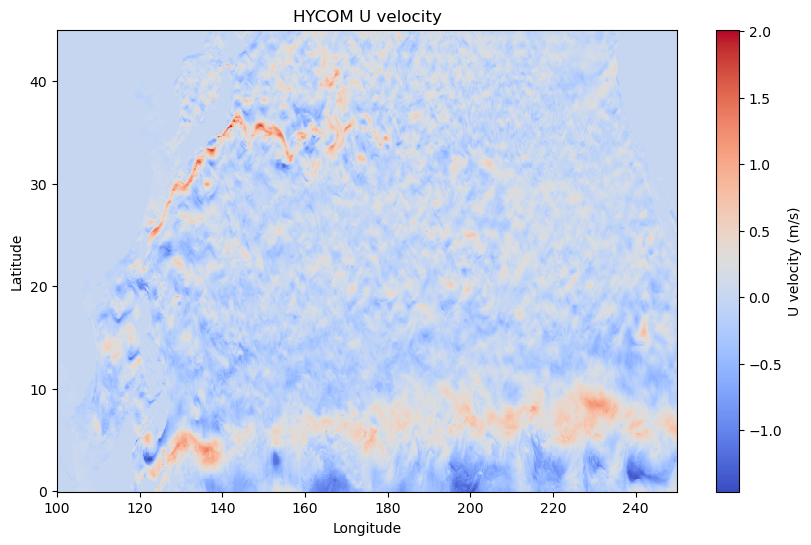

In [58]:
# plot currents to check
U = fieldset.U.data
V = fieldset.V.data
lats = fieldset.U.grid.lat
lons = fieldset.U.grid.lon

# Select the first time step and surface layer
if U.ndim == 4:
    U_plot = U[1, 2, :, :]  # time=0, depth=0
    V_plot = V[1, 2, :, :]
elif U.ndim == 3:
    U_plot = U[10800, :, :]     # time=0
    V_plot = V[10800, :, :]
else:
    U_plot = U
    V_plot = V

plt.figure(figsize=(10,6))
plt.pcolormesh(lons, lats, U_plot, shading='auto', cmap='coolwarm')
plt.colorbar(label='U velocity (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('HYCOM U velocity')
plt.show()


In [50]:
#another check of the fieldset
print("\n=== FIELDSET.U SUMMARY ===")
print(fieldset.U)

print("\n=== GRID INFORMATION ===")
print("Longitude shape:", fieldset.U.grid.lon.shape)
print("Latitude shape:", fieldset.U.grid.lat.shape)

try:
    print("Depth values:", fieldset.U.grid.depth)
    use_depth = True
except:
    print("No depth dimension detected.")
    use_depth = False

print("\nTime values:", fieldset.U.grid.time)



=== FIELDSET.U SUMMARY ===
<Field>
    name            : 'U'
    grid            : RectilinearZGrid(lon=array([ 100.00,  100.08,  100.16, ...,  249.84,  249.92,  250.00], shape=(1876,), dtype=float32), lat=array([ 0.00,  0.08,  0.16, ...,  44.80,  44.88,  44.96], shape=(563,), dtype=float32), time=array([ 0.00,  10800.00,  21600.00, ...,  2646000.00,  2656800.00,  2667600.00], shape=(248,)), time_origin=1993-01-01T00:00:00.000000000, mesh='spherical')
    extrapolate time: True
    time_periodic   : False
    gridindexingtype: 'nemo'
    to_write        : False

=== GRID INFORMATION ===
Longitude shape: (1876,)
Latitude shape: (563,)
Depth values: [  2.   6.  20.  60. 250.]

Time values: [      0.   10800.   21600.   32400.   43200.   54000.   64800.   75600.
   86400.   97200.  108000.  118800.  129600.  140400.  151200.  162000.
  172800.  183600.  194400.  205200.  216000.  226800.  237600.  248400.
  259200.  270000.  280800.  291600.  302400.  313200.  324000.  334800.
  345600. 

In [52]:
#function to see if land or water for coordinates
def is_water(lat, lon, fieldset, time=10800, depth=2.):
    """Return True if HYCOM has valid U,V at (lat, lon, depth)."""
    try:
        u = fieldset.U[time, depth, lat, lon]
        v = fieldset.V[time, depth, lat, lon]

        if np.isnan(u) or np.isnan(v):
            return False
        return True
    except:
        # Any interpolation error implies land/no data
        return False

In [53]:
#load in release coordinates to check and fix longitude since it is not 0-360 in my release file
coords = pd.read_csv('/Users/taylorely/Documents/GradStuff/Ch.2/releasepoints.csv')

print(coords.head())
print("\nColumns:", coords.columns)
print("\nData types:")
print(coords.dtypes)

coords['lon'] = (coords['lon'] + 360) % 360

print(coords.head())
print("\nColumns:", coords.columns)
print("\nData types:")
print(coords.dtypes)

# Convert to list of (lat, lon) tuples
coords = list(zip(coords['lat'], coords['lon']))

print("\nFirst 5 coords:")
for i, c in enumerate(coords[:5]):
    print(i, c)



        lat         lon
0  0.199216 -176.474156
1  0.810283 -176.611439
2  1.772442 -157.207996
3  1.772442 -157.203441
4  1.776998 -157.217106

Columns: Index(['lat', 'lon'], dtype='object')

Data types:
lat    float64
lon    float64
dtype: object
        lat         lon
0  0.199216  183.525844
1  0.810283  183.388561
2  1.772442  202.792004
3  1.772442  202.796559
4  1.776998  202.782894

Columns: Index(['lat', 'lon'], dtype='object')

Data types:
lat    float64
lon    float64
dtype: object

First 5 coords:
0 (0.199215948, 183.5258436)
1 (0.810282562, 183.3885613)
2 (1.772442473, 202.7920039)
3 (1.772442473, 202.796559)
4 (1.776997638, 202.7828935)


In [55]:
#loop through all coordinates to see if they are on land or water
for lat, lon in coords:
    if is_water(lat, lon, fieldset):
        print(lat, lon, "→ water ✔")
    else:
        print(lat, lon, "→ land/no-data ✖")

0.199215948 183.5258436 → water ✔
0.810282562 183.3885613 → water ✔
1.772442473 202.7920039 → water ✔
1.772442473 202.796559 → water ✔
1.776997638 202.7828935 → water ✔
1.776997638 202.7874487 → water ✔
1.901567982 202.4912472 → water ✔
1.91154173 202.5054056 → water ✔
1.913722805 202.5054056 → water ✔
1.984644 202.519289 → water ✔
1.966633 202.515745 → water ✔
1.829158 202.682924 → water ✔
1.948143 202.69152 → water ✔
1.948787 202.520642 → water ✔
1.976351 202.518729 → water ✔
1.836328 202.520867 → water ✔
1.859773 202.443917 → water ✔
1.93185 202.51387 → water ✔
1.987664 202.517736 → water ✔
1.925672 202.489738 → water ✔
3.872185983 200.6640871 → water ✔
3.87410285 200.6194222 → water ✔
3.875244275 200.6610289 → water ✔
3.876442924 200.6170821 → water ✔
3.878782998 200.614742 → water ✔
4.679763781 199.6557656 → water ✔
5.865034532 197.8769147 → water ✔
5.865034532 197.9582844 → water ✔
6.395411415 197.5383334 → water ✔
6.428265251 197.5711873 → water ✔
16.69091067 190.496542 → water 

In [73]:
# I don't trust chatgpt so here is just a list of u and v for a timepoint and depth per coordinate
for lat, lon in coords:
    u = fieldset.U.eval(x = lon, y = lat, z = 2, time = 10800)
    v = fieldset.V.eval(x = lon, y = lat, z = 2, time = 10800)
    print(lat, lon, u, v)

0.199215948 183.5258436 -8.0616355e-06 8.614896e-07
0.810282562 183.3885613 -6.7283167e-06 1.6879532e-07
1.772442473 202.7920039 -5.4606204e-07 2.3459283e-07
1.772442473 202.796559 -5.612612e-07 2.3650176e-07
1.776997638 202.7828935 -7.043819e-07 3.1525366e-07
1.776997638 202.7874487 -7.251456e-07 3.1786143e-07
1.901567982 202.4912472 -4.4726644e-06 1.819558e-06
1.91154173 202.5054056 -4.547656e-06 1.991413e-06
1.913722805 202.5054056 -4.5907695e-06 2.006484e-06
1.984644 202.519289 -5.218412e-06 2.488569e-06
1.966633 202.515745 -5.070044e-06 2.3713085e-06
1.829158 202.682924 -1.6637086e-06 1.4682895e-06
1.948143 202.69152 -5.424817e-06 3.4326233e-06
1.948787 202.520642 -4.878273e-06 2.3242076e-06
1.976351 202.518729 -5.144338e-06 2.4433648e-06
1.836328 202.520867 -2.861089e-06 1.5132173e-06
1.859773 202.443917 -3.9544097e-06 1.5584715e-06
1.93185 202.51387 -4.7642425e-06 2.1830533e-06
1.987664 202.517736 -5.253371e-06 2.4910523e-06
1.925672 202.489738 -4.8690754e-06 1.9423155e-06
3.872

In [74]:
# Check another timepoint
# I think chatgpt was making shit up about land having NA values because some of the coordinates are consistently 0s
for lat, lon in coords:
    u = fieldset.U.eval(x = lon, y = lat, z = 2, time = 1760400)
    v = fieldset.V.eval(x = lon, y = lat, z = 2, time = 1760400)
    print(lat, lon, u, v)

0.199215948 183.5258436 -1.1134744e-05 2.1643625e-06
0.810282562 183.3885613 -9.286461e-06 1.5894478e-06
1.772442473 202.7920039 -2.5643465e-07 1.4404085e-07
1.772442473 202.796559 -2.6351694e-07 1.4730195e-07
1.776997638 202.7828935 -3.3093409e-07 1.8784976e-07
1.776997638 202.7874487 -3.4060932e-07 1.9230473e-07
1.901567982 202.4912472 -2.267823e-06 1.2772978e-06
1.91154173 202.5054056 -2.211357e-06 1.256862e-06
1.913722805 202.5054056 -2.2157244e-06 1.2590355e-06
1.984644 202.519289 -3.1152867e-06 1.2544351e-06
1.966633 202.515745 -2.862625e-06 1.2610087e-06
1.829158 202.682924 -8.7897644e-07 6.599514e-07
1.948143 202.69152 -2.4247583e-06 1.2206805e-06
1.948787 202.520642 -2.5937359e-06 1.2421452e-06
1.976351 202.518729 -2.996535e-06 1.2543064e-06
1.836328 202.520867 -1.9178751e-06 1.154228e-06
1.859773 202.443917 -2.6815744e-06 1.4258675e-06
1.93185 202.51387 -2.369173e-06 1.2536007e-06
1.987664 202.517736 -3.1613554e-06 1.2608089e-06
1.925672 202.489738 -2.3586558e-06 1.3008722e-0